# Librerías

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Carga y preprocesamiento de datos de entrenamiento

In [3]:
def load_and_preprocess_data():
    train_data = pd.read_csv('train_hora.csv')
    temp_max = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_maxima.csv')
    temp_media = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_media.csv')
    temp_min = pd.read_csv('DMC_330020_Quinta_Normal_Santiago_minima.csv')

    for df in [train_data, temp_max, temp_media, temp_min]:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    combined_data = train_data.join([temp_max['t_maxima'], temp_media['t_media'], temp_min['t_minima']], how='inner')
    combined_data.columns = ['consumption', 't_maxima', 't_media', 't_minima']

    scalers = {}
    for col in combined_data.columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        combined_data[f"{col}_scaled"] = scaler.fit_transform(combined_data[col].values.reshape(-1, 1))
        scalers[col] = scaler

    data_for_model = combined_data[['consumption_scaled', 't_maxima_scaled', 't_media_scaled', 't_minima_scaled']]

    return data_for_model, scalers

data_for_model, scalers = load_and_preprocess_data()

# Función Secuencia

In [4]:
def create_sequences(data, seq_length, output_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length - output_length + 1):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length:i + seq_length + output_length, 0])
    return np.array(sequences), np.array(targets)


sequence_length = 24 * 7
output_length = 1


train, test = train_test_split(data_for_model, test_size=0.2, shuffle=False)

X_train, y_train = create_sequences(train.values, sequence_length, output_length)
X_test, y_test = create_sequences(test.values, sequence_length, output_length)


# API funcional

In [5]:
def build_model(input_shape, output_length):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(output_length)(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

model = build_model((X_train.shape[1], X_train.shape[2]), output_length)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 168, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 168, 128)       │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,569 (459.25 KB)

 Trainable params: 117,569 (459.25 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

model.save('modelo2_LSTM_temp.keras')

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 0.1967 - mae: 0.3358 - val_loss: 0.0081 - val_mae: 0.0761
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0107 - mae: 0.0813 - val_loss: 0.0034 - val_mae: 0.0471
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0076 - mae: 0.0683 - val_loss: 0.0033 - val_mae: 0.0452
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0086 - mae: 0.0707 - val_loss: 0.0032 - val_mae: 0.0448
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0073 - mae: 0.0656 - val_loss: 0.0032 - val_mae: 0.0455
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0072 - mae: 0.0641 - val_loss: 0.0036 - val_mae: 0.0475
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0068 - mae: 0.0624 - val_loss: 0.0033 - val_mae: 0.0458
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0068 - mae: 0.0626 - val_loss: 0.0035 - val_mae: 0.0461
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/

# Visualización: Pérdida durante entrenamiento

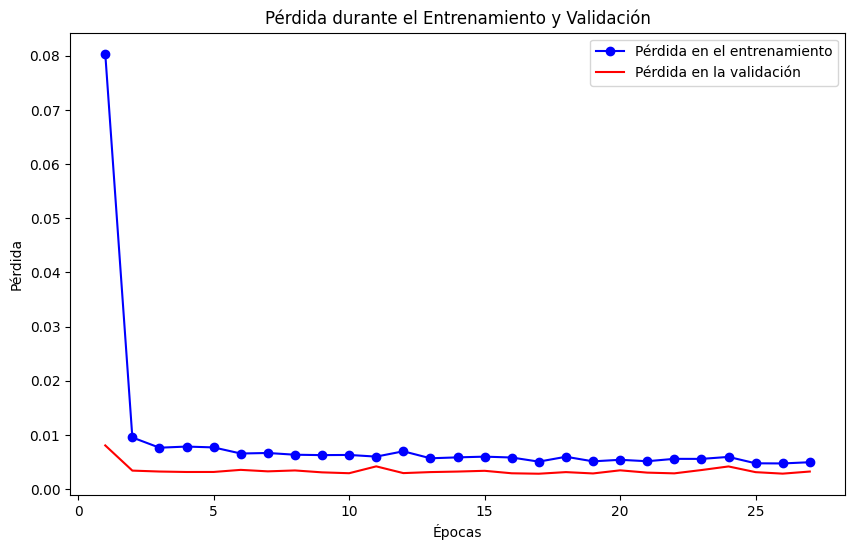

In [7]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo-', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_values, 'r-', label='Pérdida en la validación')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluación y métricas

In [15]:
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
    return predictions_rescaled, y_test_rescaled, mae, rmse, mse


predictions_rescaled, y_test_rescaled, mae, rmse, mse = evaluate_model(model, X_test, y_test, scalers['consumption'])

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
MAE: 3.5787059999189457
MSE: 21.406372809351275
RMSE: 4.626702152651635


In [ ]:
def predict_sequential(model, initial_input, steps_ahead):
    predictions = []
    current_input = initial_input
    for _ in range(steps_ahead):
        pred = model.predict(current_input)
        predictions.append(pred)
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[:, -1, 0] = pred
    return np.array(predictions).flatten()

initial_input = X_test[:1]  
predictions_sequential = predict_sequential(model, initial_input, steps_ahead=168)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

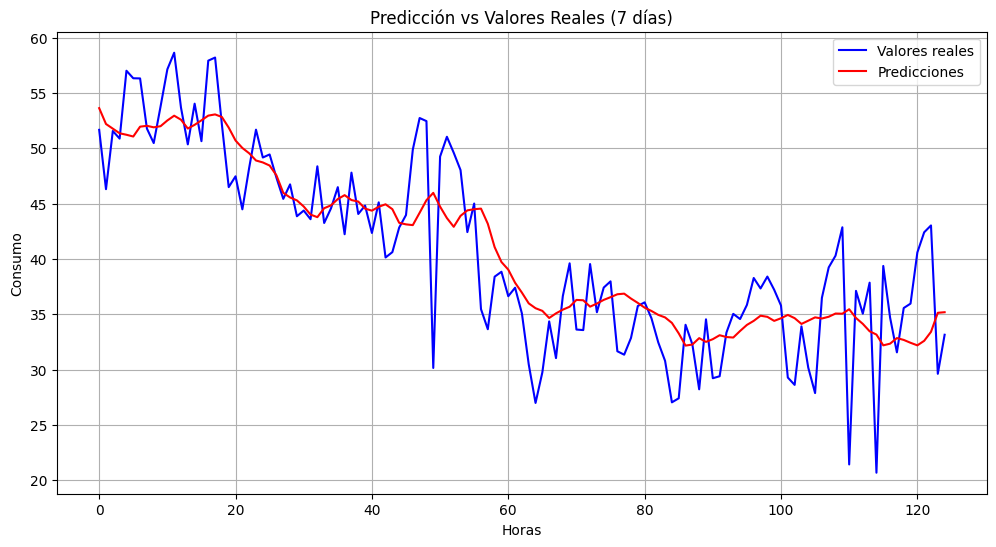

In [ ]:
def plot_predictions(y_true, y_pred, total_hours=168):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true[:total_hours].flatten(), label='Valores reales', color='blue')
    plt.plot(y_pred[:total_hours].flatten(), label='Predicciones', color='red')
    plt.title(f'Predicción vs Valores Reales (7 días)')
    plt.xlabel('Horas')
    plt.ylabel('Consumo')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(y_test_rescaled, predictions_rescaled, total_hours=168)

In [ ]:
mse_train = history.history['loss'] 
mse_val = history.history['val_loss']  

mae_train = history.history['mae']  
mae_val = history.history['val_mae']  

rmse_train = [np.sqrt(x) for x in mse_train]
rmse_val = [np.sqrt(x) for x in mse_val]

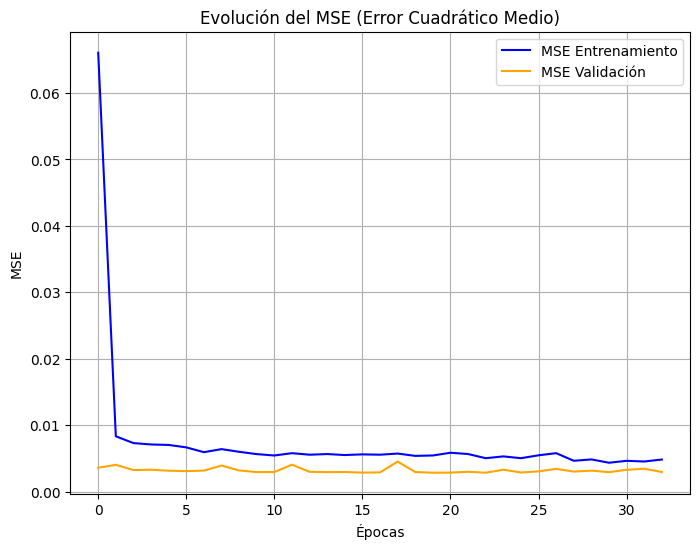

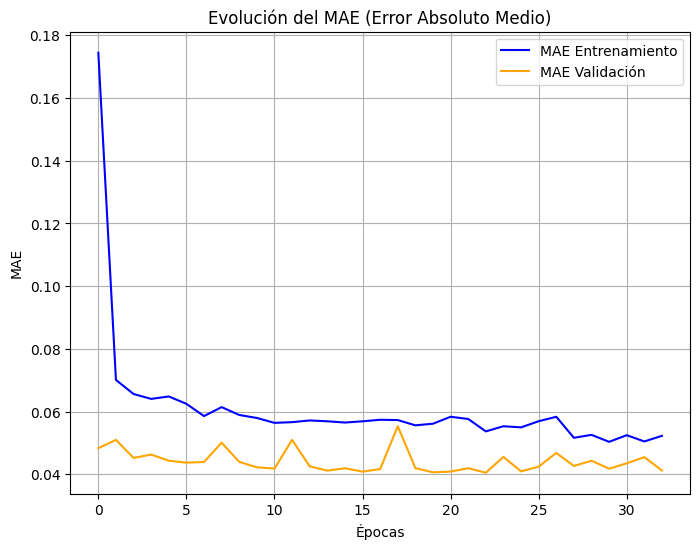

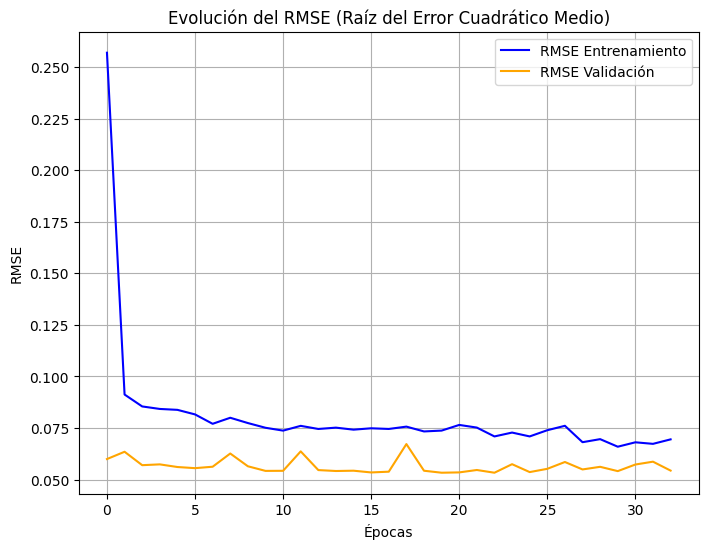

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(mse_train, label='MSE Entrenamiento', color='blue')
plt.plot(mse_val, label='MSE Validación', color='orange')
plt.title('Evolución del MSE (Error Cuadrático Medio)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(mae_train, label='MAE Entrenamiento', color='blue')
plt.plot(mae_val, label='MAE Validación', color='orange')
plt.title('Evolución del MAE (Error Absoluto Medio)')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(rmse_train, label='RMSE Entrenamiento', color='blue')
plt.plot(rmse_val, label='RMSE Validación', color='orange')
plt.title('Evolución del RMSE (Raíz del Error Cuadrático Medio)')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()
